# Demonstration of `xply`
## System definition (can be skipped for tutorial)
For this demo we will use a Morris-Lecar biophysical neuronal model. The system is described by a membrane potential variable $v$ and a potassium variable $w$, with the corresponding equations:

\begin{align}
\dot v & = -g_l(v-v_l) - g_k w (v-v_k) - g_{Ca} m_{\infty}(v)(v-v_{Ca}) + I_{app}, \\
\dot w & = -\frac{w-w_{\infty}}{\tau},
\end{align}

where $g_l$, $g_k$, $g_{Ca}$ are the leak, potassium, and calcium conductances respectively. Parameters $v_l$, $v_k$, and $v_{Ca}$ are the respective reversal potentials. Finally, $I_{app}$ is a DC, and $w_{\infty}$ as well as $m_{\infty}$ are the voltage dependent asymptotic functions of potassium and calcium.

We define the system in the attached `XPP` file `ml.ode`.

## Basic functionality
`xply` allows us to test the correctness of the `XPP` file by doing a `dry-run`, which prints the output from `XPP` and also any possible syntactic bugs.

### Dry run to check syntax (`dru_run`)

In [1]:
import scipy as sp
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import xply.xply as xply


ODE = 'ml.ode'
res = xply.dry_run(ODE)
print(res.stdout.decode('utf-8'))


output.datParameters:
|G|=0.600000 
Parameters:
|GL|=0.150000 |GCA|=0.300000 |GK|=0.600000 
Parameters:
|VK|=-70.000000 |VL|=-50.000000 |VCA|=100.000000 
Parameters:
|VA|=1.000000 |VB|=14.500000 |VC|=4.000000 |VD|=15.000000 
Parameters:
|IAPP|=6.000000 |TAUW|=100.000000 
Parameters:
|TAUD|=1000.000000 
Parameters:
|TAUS|=100.000000 
Parameters:
|VTHETA|=0.000000 
 Added user fun MINF 
 Added user fun WINF 
 Added user fun H 
VSCALED = v/50   
MINF(V)=.5*(1+TANH((V-VA)/VB))  
WINF(V)= .5*(1+TANH((V-VC)/VD))  
H(X)=.5+.5*TANH(0.2*X)  
0:dV/dt= -GL*(V-VL)-GK*W*(V-VK)-GCA*MINF(V)*(V-VCA)+IAPP  
1:dW/dt= (WINF(V)-W)/TAUW  
 Initial V(0)=-5
 Initial W(0)=0.1
vscaled=v/50  
 All formulas are valid!!
 nvar=2 naux=1 nfix=0 nmark=0 NEQ=3 NODE=3 
Used 22 constants and 127 symbols 
XPPAUT 8.0 Copyright (C) 2002-now  Bard Ermentrout 
It's a dry run...



No errors, great!

## Version check (`version`)
Since `XPP` version 8.0 (from 2015) implemented a number of useful commandline options, `xply` ony runs with this and higher versions. We can test the version directly from `xply`:

In [2]:
xply.version(ODE)

8.0

Fantastic, now we can start with the actual *useful* features of `xply`.

## Querying data
Often we want to get access to things like parameters, numerical options, initial conditions etc. which were defined in the `XPP` file. We can do this as follows:

### Querying state variables (`read_state_vars`)
This gives us a `numpy` array with the state variables. 

In [3]:
xply.read_state_vars(ODE)

array(['v', 'w'], dtype='<U1')

### Querying parameters (`read_pars`)
Since keeping track of the order of parameters is often necessary, this function returns a `collections.OrderedDict` with the parameters. 

In [4]:
xply.read_pars(ODE)

OrderedDict([('g', 0.6),
             ('gl', 0.15),
             ('gca', 0.3),
             ('gk', 0.6),
             ('vk', -70.0),
             ('vl', -50.0),
             ('vca', 100.0),
             ('va', 1.0),
             ('vb', 14.5),
             ('vc', 4.0),
             ('vd', 15.0),
             ('iapp', 6.0),
             ('tauw', 100.0),
             ('taud', 1000.0),
             ('taus', 100.0),
             ('vtheta', 0.0)])

### Querying initial conditions (`read_inits`)
Initial conditions are returned as a `numpy` array, and they occur in the same order as the state variables.

In [5]:
xply.read_inits(ODE)

array([-5. ,  0.1])

### Querying numeric options (`read_opts`)

In [6]:
xply.read_opts(ODE)

OrderedDict([('total', 5000.0),
             ('dt', '0.5'),
             ('xlo', '-64'),
             ('xhi', 75.0),
             ('ylo', '-1'),
             ('yhi', '1.0'),
             ('xplot', 'v'),
             ('yplot', 'w'),
             ('maxstor', 40000000.0),
             ('bounds', 100000.0),
             ('method', 'stiff'),
             ('nmesh', 150.0),
             ('simplot', 1.0)])

## Running `XPP`
### Running simulations (`run`)
With the default arguments, `run` integrates the system from the options and parameters defined in the `XPP` file. The output is stored in an `ndarray`, where the first column is time, and the remaining columns are ordered according to the definition order of the state variables and auxilliary variables.

In [7]:
dat = xply.run(ODE)
dat

array([[   0.        ,   -5.        ,    0.1       ,   -0.1       ],
       [   0.5       ,   -2.1002619 ,    0.10082901,   -0.04200524],
       [   1.        ,    1.9337839 ,    0.10214417,    0.03867568],
       ...,
       [4999.        ,   35.622208  ,    0.20861031,    0.71244413],
       [4999.5       ,   35.167614  ,    0.21248266,    0.70335227],
       [5000.        ,   34.716087  ,    0.21633111,    0.69432175]])

For the Morris-Lecar neuron, we get the typical spiking limit cycle:

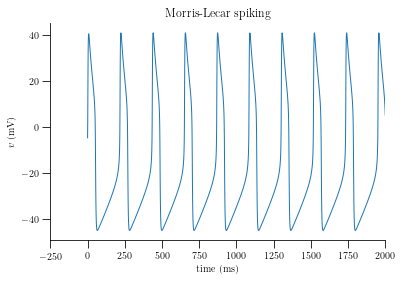

In [8]:
fig, ax = plt.subplots()
ax.plot(dat[:, 0], dat[:, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'$v$ (mV)')
ax.set_xlim(right=2000)
ax.set_title('Morris-Lecar spiking')
fig.show()

We can conveniently change initial conditions by specifying the argument `inits`.

In [9]:
inits = xply.read_inits(ODE)
inits[0] = -100    # Change voltage
dat = xply.run(ODE, inits=inits)
dat

array([[   0.        , -100.        ,    0.1       ,   -2.        ],
       [   0.5       ,  -92.739693  ,    0.09950126,   -1.8547938 ],
       [   1.        ,  -86.205246  ,    0.09900501,   -1.7241049 ],
       ...,
       [4999.        ,  -21.903385  ,    0.10260235,   -0.4380677 ],
       [4999.5       ,  -21.744646  ,    0.10224509,   -0.43489289],
       [5000.        ,  -21.582609  ,    0.10189284,   -0.43165219]])

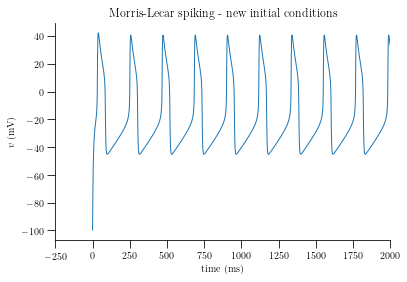

In [10]:
fig, ax = plt.subplots()
ax.plot(dat[:, 0], dat[:, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'$v$ (mV)')
ax.set_xlim(right=2000)
ax.set_title('Morris-Lecar spiking - new initial conditions')
fig.show()

We can also change other things such as parameters or numeric options by simply providing them as keyword arguments.

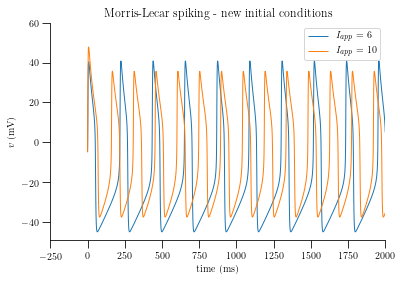

In [11]:
iapps = [6, 10]

dat1 = xply.run(ODE, iapp=iapps[0])
dat2 = xply.run(ODE, iapp=iapps[1])

fig, ax = plt.subplots()
for idx, dat in enumerate([dat1, dat2]):
    ax.plot(dat[:, 0], dat[:, 1], label=r'$I_{app}=%s$' % iapps[idx])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('time (ms)')
    ax.set_ylabel(r'$v$ (mV)')
    ax.set_xlim(right=2000)
    ax.set_title('Morris-Lecar spiking - new initial conditions')
    ax.legend(loc='upper right')
    ax.set_ylim(top=60)
fig.show()

### Computing nullclines (`nullclines`)
`xply` also allows us to compute the nullclines of the system, in this case the equations $v_\infty$ and $w_\infty$ satisfying

\begin{align}
\dot v & = 0,\\
\dot w & = 0,\\
\end{align}

respectively. We call function `nullclines` as follows:

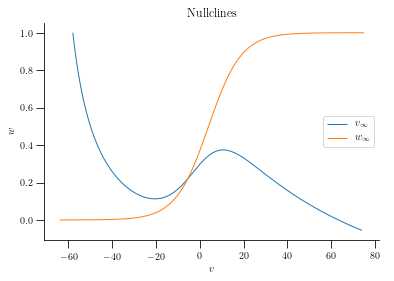

In [12]:
n1, n2 = xply.nullclines(ODE, xplot='v', yplot='w')

fig, ax = plt.subplots()
ax.plot(n1[:, 0], n1[:, 1], label=r'$v_\infty$')
ax.plot(n2[:, 0], n2[:, 1], label=r'$w_\infty$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$w$')
ax.set_title('Nullclines')
ax.legend()
fig.show()

Similar to `run`, we can also change numeric options, parameters etc...
Here we increase $I_{app}$ to $15$ and we notice that the $v$-nullcline $v_\infty$ moves up in the $(v,w)$-plane.

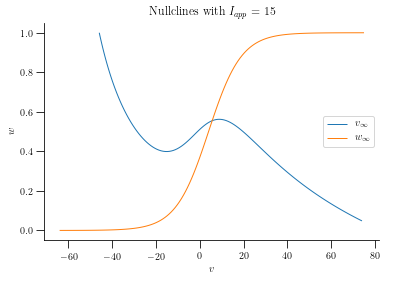

In [13]:
n1, n2 = xply.nullclines(ODE, xplot='v', yplot='w', iapp=15)

fig, ax = plt.subplots()
ax.plot(n1[:, 0], n1[:, 1], label=r'$v_\infty$')
ax.plot(n2[:, 0], n2[:, 1], label=r'$w_\infty$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$w$')
ax.set_title('Nullclines with ' + r'$I_{app}=15$')
ax.legend()
fig.show()

And that's it! More features to come!